In [ ]:
from google.colab import files
uploaded = files.upload()


Saving StockMarket.zip to StockMarket.zip


In [ ]:
import pandas as pd
import zipfile
import os

zip_path = 'StockMarket.zip'  # Your ZIP file path
extract_dir = 'stock_data_temp'  # Temporary folder to extract CSVs

# Extract all files from ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# List all CSV files extracted
all_files = [os.path.join(extract_dir, f) for f in os.listdir(extract_dir) if f.endswith('.csv')]
print(f'Found {len(all_files)} CSV files.')


Found 52 CSV files.


In [ ]:
# Read each CSV and combine into one DataFrame
df_list = []
for file in all_files:
    df = pd.read_csv(file)
    df_list.append(df)

data = pd.concat(df_list, ignore_index=True)
print(f'Combined data shape: {data.shape}')


Combined data shape: (470434, 18)


<ipython-input-15-84dc50e071fa>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat(df_list, ignore_index=True)


In [ ]:
import numpy as np

# Drop columns that are not numeric (e.g., Date)
for col in data.columns:
    if not np.issubdtype(data[col].dtype, np.number):
        data.drop(columns=col, inplace=True)

print(f'Data columns after removing non-numeric: {data.columns.tolist()}')


Data columns after removing non-numeric: ['Prev Close', 'Open', 'High', 'Low', 'Last', 'Close', 'VWAP', 'Volume', 'Turnover', 'Trades', 'Deliverable Volume', '%Deliverble', 'HL_PCT', 'PCT_change', 'Close_next']


In [ ]:
# Add lag features for Close price (previous 1, 2, 3 days)
for lag in range(1, 4):
    data[f'Close_lag_{lag}'] = data['Close'].shift(lag)

# Drop rows with NaN after lagging
data.dropna(inplace=True)

# Update feature columns to include lag features
feature_cols = [
    'Prev Close', 'Open', 'High', 'Low', 'Last', 'Close', 'VWAP', 'Volume',
    'Turnover', 'Trades', 'Deliverable Volume', '%Deliverble', 'HL_PCT', 'PCT_change',
    'Close_lag_1', 'Close_lag_2', 'Close_lag_3'
]

# Create target column: next day Close price
data['Close_next'] = data['Close'].shift(-1)
data.dropna(inplace=True)

# Prepare X and y
X = data[feature_cols]
y = data['Close_next']


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize scaler and fit on training features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}')


Training samples: 192545, Testing samples: 48137


In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor

# Initialize and train HistGradientBoostingRegressor
gb_model = HistGradientBoostingRegressor(max_iter=100, random_state=42)
gb_model.fit(X_train_scaled, y_train)


HistGradientBoostingRegressor(random_state=42)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Predict on test data
y_pred_gb = gb_model.predict(X_test_scaled)

# Calculate metrics
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f'HistGradientBoostingRegressor MSE: {mse_gb:.4f}')
print(f'HistGradientBoostingRegressor R-squared: {r2_gb:.4f}')


HistGradientBoostingRegressor MSE: 30335.7530
HistGradientBoostingRegressor R-squared: 0.9975


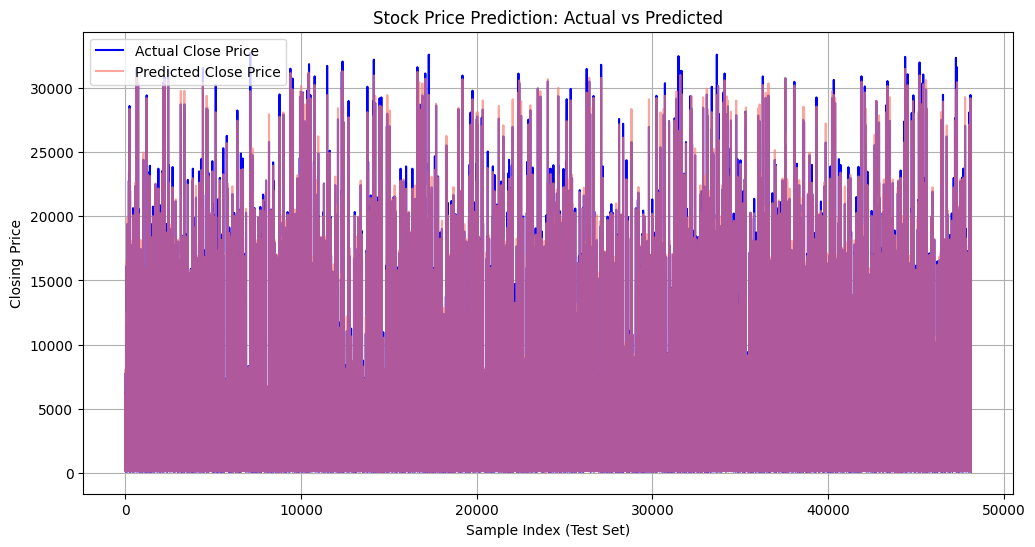

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Close Price', color='blue')
plt.plot(y_pred_gb, label='Predicted Close Price', color='salmon', alpha=0.7)
plt.title('Stock Price Prediction: Actual vs Predicted')
plt.xlabel('Sample Index (Test Set)')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()
